# Astrophotography Image Denoising using Deep Learning

In this notebook we will analyze the denoised FITS files produced by our DL models (N2V and N2N). We will extract SNR, CNR, and FWHM metrics and visualize the results.

In [92]:
# import necessary libraries
import warnings
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
from IPython.display import display
from astropy.coordinates import SkyCoord
from utils import do_aperture_photometry
from photutils.centroids import centroid_sources, centroid_com

# Astropy throws fixing errors that can be ignored
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)   

## Loading Data from FITS files

Here we load the denoised n2n and n2v files from the directory 'Denoised_Science', which we will then make two dataframes (n2n and n2v) which will include:

1. SNR (Signal-to-Noise Ratio)
2. CNR (Contrast-to-Noise Ratio)
3. FWHM (Full-Width-Half-Maximum)

We will also make a dataframe for the calibrated data to be used as our baseline.

In [93]:
# Grab denoised files from N2V and N2N models
n2v_files = sorted(Path('Denoised_Science').glob('n2v_*.fits'))
n2n_files = sorted(Path('Denoised_Science').glob('n2n_*.fits'))

print(f'Found {len(n2v_files)} N2V denoised files.')
print(f'Found {len(n2n_files)} N2N denoised files.')

# Grab calibrated science files for baseline comparison
calibrated_files = sorted(Path('Science').glob('calibrated_*.fits'))
print(f'Found {len(calibrated_files)} calibrated science files for baseline comparison.')

Found 30 N2V denoised files.
Found 30 N2N denoised files.
Found 30 calibrated science files for baseline comparison.


## Extracting Metrics

Now we can extract the three metrics from each file and populate the dataframes.

Below we make a helper function to extract the SNR, CNR, and FWHM given a filepath.

In [94]:
def extract_metrics(file):
    """ Extract SNR, CNR, and FWHM from a denoised FITS file.

    Args:
        file (str): Path to the FITS file.

    Returns:
        tuple: SNR, CNR, FWHM values.
    """
    science      = fits.open(file)
    science_data = science[0].data.astype(float)
    science_wcs  = WCS(science[0].header)
    if 'CTYPE1' not in science[0].header:   # Some files don't have celestial coordinates due to technical errors
        return

    # Get target coordinates from header
    target_ra    = science[0].header['RA']
    target_dec   = science[0].header['DEC']
    target_coord = SkyCoord(ra=target_ra, dec=target_dec, frame='icrs', unit=(u.hourangle, u.deg))

    # Find target position in pixels
    x, y     = target_coord.to_pixel(science_wcs)
    position = centroid_sources(science_data - np.median(science_data), xpos=x, ypos=y, box_size=25, centroid_func=centroid_com)
    position = (int(position[0][0]), int(position[1][0]))

    # Photometry parameters inferred by first looking at data and then testing
    photometry_radius = 12
    annulus_radius    = 18
    annulus_width     = 4

    # Use custom function to compute SNR, CNR, FWHM; see utils.py
    snr, cnr, fwhm = do_aperture_photometry(science_data, position, photometry_radius, annulus_radius, annulus_width)

    return snr, cnr, fwhm

In [95]:
n2n_data = []
n2v_data = []
cal_data = []

for n2n_file in n2n_files:
    filename = n2n_file.stem.split('_')[-1]

    n2n_metrics = extract_metrics(n2n_file)
    if n2n_metrics is None:
        continue
    snr, cnr, fwhm = n2n_metrics
    n2n_data.append([filename, snr, cnr, fwhm])

for n2v_file in n2v_files:
    metrics = extract_metrics(n2v_file)
    if metrics is None:
        continue
    snr, cnr, fwhm = metrics
    n2v_data.append([n2v_file.stem.split('_')[-1], snr, cnr, fwhm])

for cal_file in calibrated_files:
    metrics = extract_metrics(cal_file)
    if metrics is None:
        continue
    snr, cnr, fwhm = metrics
    cal_data.append([cal_file.stem.split('_')[-1], snr, cnr, fwhm])

n2n_df = pd.DataFrame(n2n_data, columns=['filename', 'snr', 'cnr', 'fwhm'])
n2v_df = pd.DataFrame(n2v_data, columns=['filename', 'snr', 'cnr', 'fwhm'])
cal_df = pd.DataFrame(cal_data, columns=['filename', 'snr', 'cnr', 'fwhm'])

print("N2N DataFrame:")
print('SNR Mean:', n2n_df['snr'].mean())
print('SNR σ:', n2n_df['snr'].std())
display(n2n_df.head())

print("N2V DataFrame:")
print('SNR Mean:', n2v_df['snr'].mean())
print('SNR σ:', n2v_df['snr'].std())
display(n2v_df.head())

print("Calibrated DataFrame:")
print('SNR Mean:', cal_df['snr'].mean())
print('SNR σ:', cal_df['snr'].std())
display(cal_df.head())

N2N DataFrame:
SNR Mean: 60.29688854396737
SNR σ: 5.947977347722826


,filename,snr,cnr,fwhm
0,051532,56.412352,21698.950283,8.361236
1,051615,55.003747,24645.583187,7.811383
2,051657,57.413030,31758.536688,7.710795
3,051738,58.454667,996.406616,7.637999
4,052449,58.817234,16780.677890,8.680509


N2V DataFrame:
SNR Mean: 59.44438966189477
SNR σ: 6.169047099327466


,filename,snr,cnr,fwhm
0,051532,56.256346,18084.151389,6.351390
1,051615,52.825130,28611.598609,5.699505
2,051657,53.568557,40033.595799,5.608669
3,051738,54.815488,714.621127,5.534528
4,052449,59.585151,9021.486784,6.382005


Calibrated DataFrame:
SNR Mean: 54.34933748273754
SNR σ: 5.82774425529132


,filename,snr,cnr,fwhm
0,051532,50.914946,1596.654709,5.234828
1,051615,47.076976,1406.572776,4.524842
2,051657,51.436467,1588.046407,4.386288
3,051738,51.310241,608.933574,4.321109
4,052449,51.106499,1542.123704,5.152677


## Analysis

Now that the dataframes are populated, we can proceed with the analysis. We will analyze the distributions for SNR, CNR, and FWHM and determine if there was an improvement!

### SNR

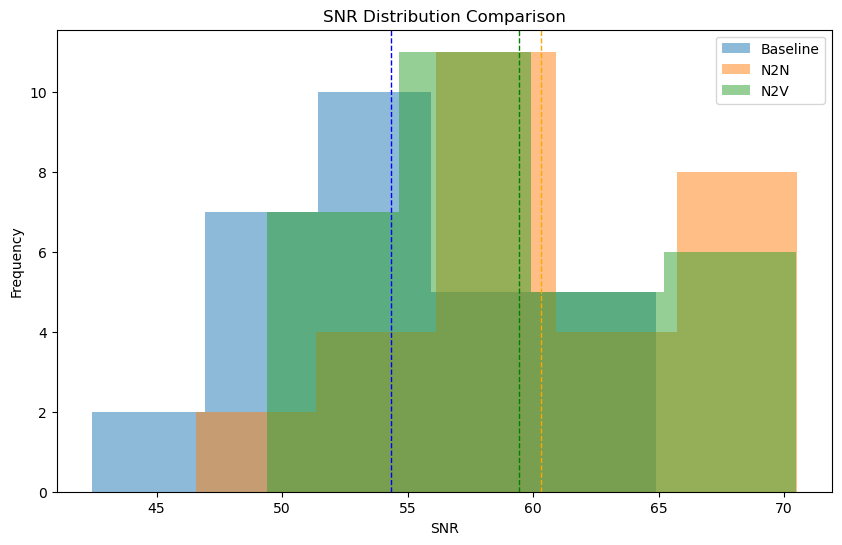

In [96]:
# Compare SNR distributions between N2N and N2V, using the calibrated data as our baseline.

plt.figure(figsize=(10, 6))
plt.hist(cal_df['snr'], bins='fd', alpha=0.5, label='Baseline')
plt.hist(n2n_df['snr'], bins='fd', alpha=0.5, label='N2N')
plt.hist(n2v_df['snr'], bins='fd', alpha=0.5, label='N2V')

# Vertical lines for means
plt.axvline(cal_df['snr'].mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(n2n_df['snr'].mean(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(n2v_df['snr'].mean(), color='green', linestyle='dashed', linewidth=1)

# Labels and legend
plt.xlabel('SNR')
plt.ylabel('Frequency')
plt.title('SNR Distribution Comparison')
plt.legend();

Out of visual inspection, looks like N2N and N2V already made an improvement!

Now we will plot the SNR vs the baseline SNR

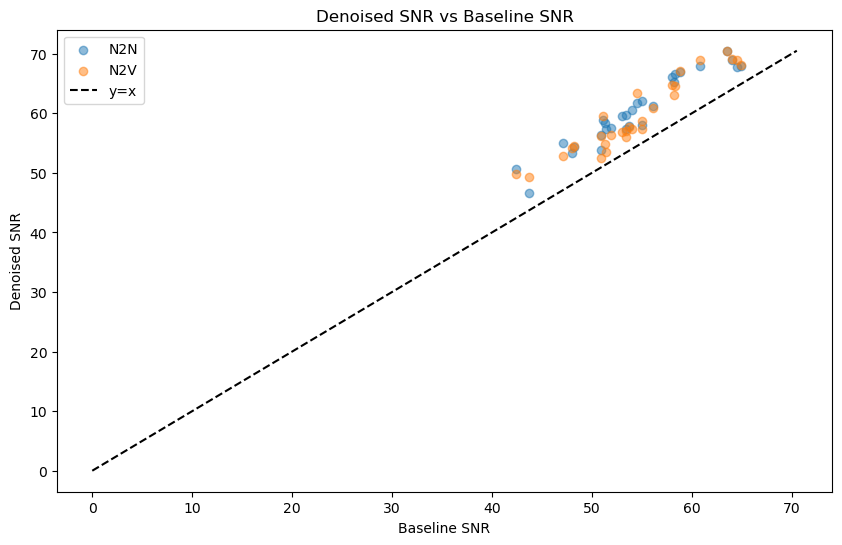

In [97]:
# Plot SNR against baseline SNR for N2N and N2V
plt.figure(figsize=(10, 6))
plt.scatter(cal_df['snr'], n2n_df['snr'], alpha=0.5, label='N2N')
plt.scatter(cal_df['snr'], n2v_df['snr'], alpha=0.5, label='N2V')
plt.plot([0, max(cal_df['snr'].max(), n2n_df['snr'].max(), n2v_df['snr'].max())], [0, max(cal_df['snr'].max(), n2n_df['snr'].max(), n2v_df['snr'].max())], 'k--', label='y=x')
plt.xlabel('Baseline SNR')
plt.ylabel('Denoised SNR')
plt.title('Denoised SNR vs Baseline SNR')
plt.legend();

### CNR

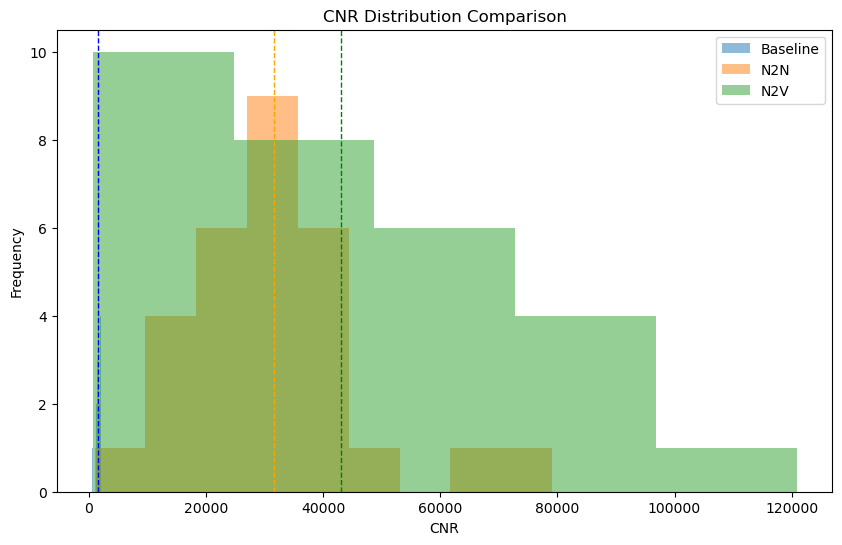

In [98]:
# Compare CNR distributions between N2N and N2V, using the calibrated data as our baseline.
plt.figure(figsize=(10, 6))
plt.hist(cal_df['cnr'], bins='fd', alpha=0.5, label='Baseline')
plt.hist(n2n_df['cnr'], bins='fd', alpha=0.5, label='N2N')
plt.hist(n2v_df['cnr'], bins='fd', alpha=0.5, label='N2V')

# Vertical lines for means
plt.axvline(cal_df['cnr'].mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(n2n_df['cnr'].mean(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(n2v_df['cnr'].mean(), color='green', linestyle='dashed', linewidth=1)

# Labels and legend
plt.xlabel('CNR')
plt.ylabel('Frequency')
plt.title('CNR Distribution Comparison')
plt.legend();

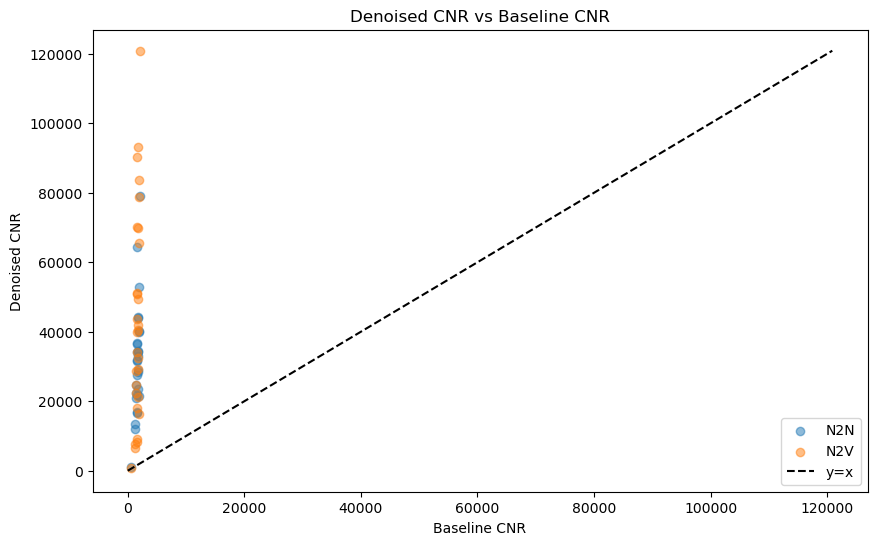

In [99]:
# Plot CNR vs baseline CNR for N2N and N2V
plt.figure(figsize=(10, 6))
plt.scatter(cal_df['cnr'], n2n_df['cnr'], alpha=0.5, label='N2N')
plt.scatter(cal_df['cnr'], n2v_df['cnr'], alpha=0.5, label='N2V')
plt.plot([0, max(cal_df['cnr'].max(), n2n_df['cnr'].max(), n2v_df['cnr'].max())], [0, max(cal_df['cnr'].max(), n2n_df['cnr'].max(), n2v_df['cnr'].max())], 'k--', label='y=x')
plt.xlabel('Baseline CNR')
plt.ylabel('Denoised CNR')
plt.title('Denoised CNR vs Baseline CNR')
plt.legend();

Defintely much better CNR, however this could be due to the models aggreively removing local noise around the 'signals' to make a huge contrast.

### FWHM

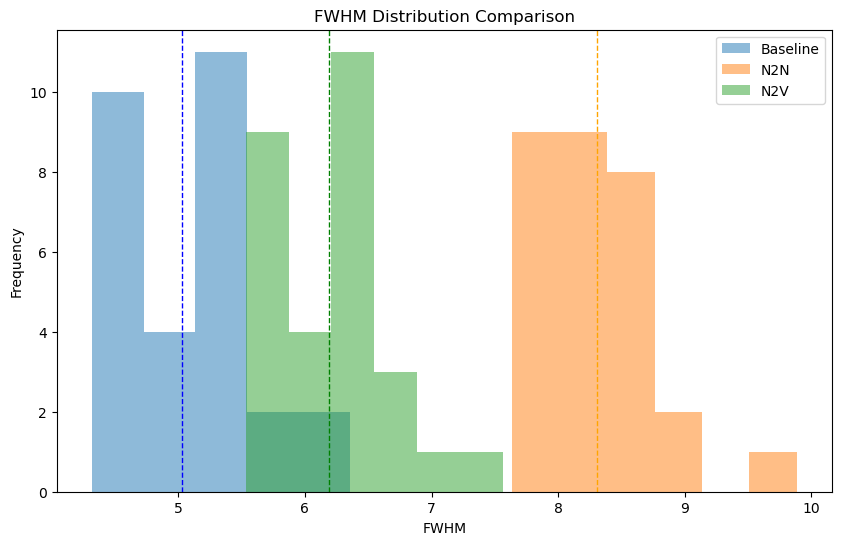

In [100]:
# Compare FWHM distributions between N2N and N2V, using the calibrated data as our baseline.
plt.figure(figsize=(10, 6))
plt.hist(cal_df['fwhm'], bins='fd', alpha=0.5, label='Baseline')
plt.hist(n2n_df['fwhm'], bins='fd', alpha=0.5, label='N2N')
plt.hist(n2v_df['fwhm'], bins='fd', alpha=0.5, label='N2V')

# Vertical lines for means
plt.axvline(cal_df['fwhm'].mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(n2n_df['fwhm'].mean(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(n2v_df['fwhm'].mean(), color='green', linestyle='dashed', linewidth=1)

# Labels and legend
plt.xlabel('FWHM')
plt.ylabel('Frequency')
plt.title('FWHM Distribution Comparison')
plt.legend();

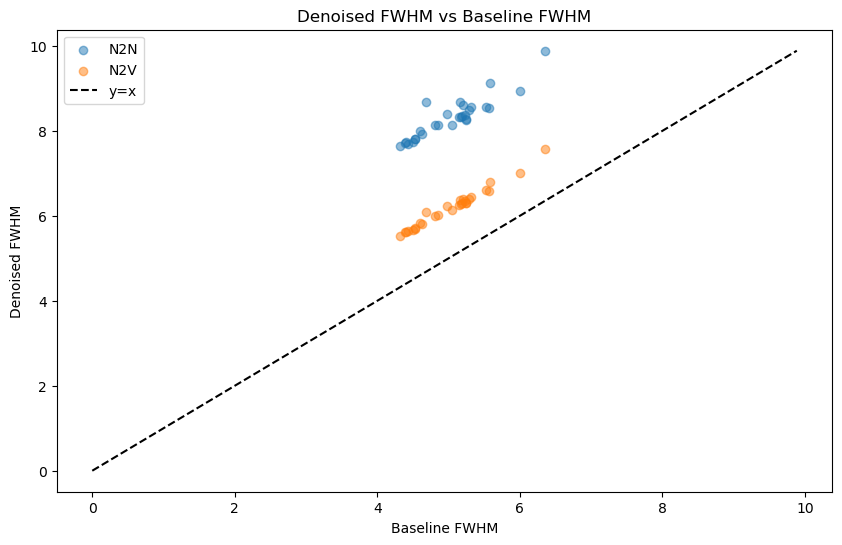

In [101]:
# Plot FWHM vs baseline FWHM for N2N and N2V
plt.figure(figsize=(10, 6))
plt.scatter(cal_df['fwhm'], n2n_df['fwhm'], alpha=0.5, label='N2N')
plt.scatter(cal_df['fwhm'], n2v_df['fwhm'], alpha=0.5, label='N2V')
plt.plot([0, max(cal_df['fwhm'].max(), n2n_df['fwhm'].max(), n2v_df['fwhm'].max())], [0, max(cal_df['fwhm'].max(), n2n_df['fwhm'].max(), n2v_df['fwhm'].max())], 'k--', label='y=x')
plt.xlabel('Baseline FWHM')
plt.ylabel('Denoised FWHM')
plt.title('Denoised FWHM vs Baseline FWHM')
plt.legend();

As seen above, both n2n and n2v increase FWHM, which is unwanted in astrophotography since we want sharper edges to distinguish between noise and signal.

## Cross correlation

We want to check the cross correlation between two different images for each model (baseline/n2n/n2v) and ensure that random noise is preserved as we don't want to introduce systematic errors.

We should expect high correlation for signals (i.e. stars) between the images and very little to no correlation for noisy regions.

In [103]:
# Check cross correlation of first two images before and after denoising

from scipy.signal import fftconvolve
def cross_correlation(image1, image2):
    """ Compute the normalized cross-correlation between two images.

    Args:
        image1 (ndarray): First image.
        image2 (ndarray): Second image.
    Returns:
        ndarray: Normalized cross-correlation array.
    """
    # Compute the cross-correlation
    corr = fftconvolve(image1, image2, mode='full')
    # Normalize
    corr /= np.sqrt(np.sum(image1**2) * np.sum(image2**2))
    return corr

n2n_image1 = fits.open(n2n_files[0])[0].data.astype(float)
n2n_image2 = fits.open(n2n_files[1])[0].data.astype(float)
n2v_image1 = fits.open(n2v_files[0])[0].data.astype(float)
n2v_image2 = fits.open(n2v_files[1])[0].data.astype(float)
cal_image1 = fits.open(calibrated_files[0])[0].data.astype(float)
cal_image2 = fits.open(calibrated_files[1])[0].data.astype(float)

n2n_corr = cross_correlation(n2n_image1, n2n_image2)
n2v_corr = cross_correlation(n2v_image1, n2v_image2)
cal_corr = cross_correlation(cal_image1, cal_image2)

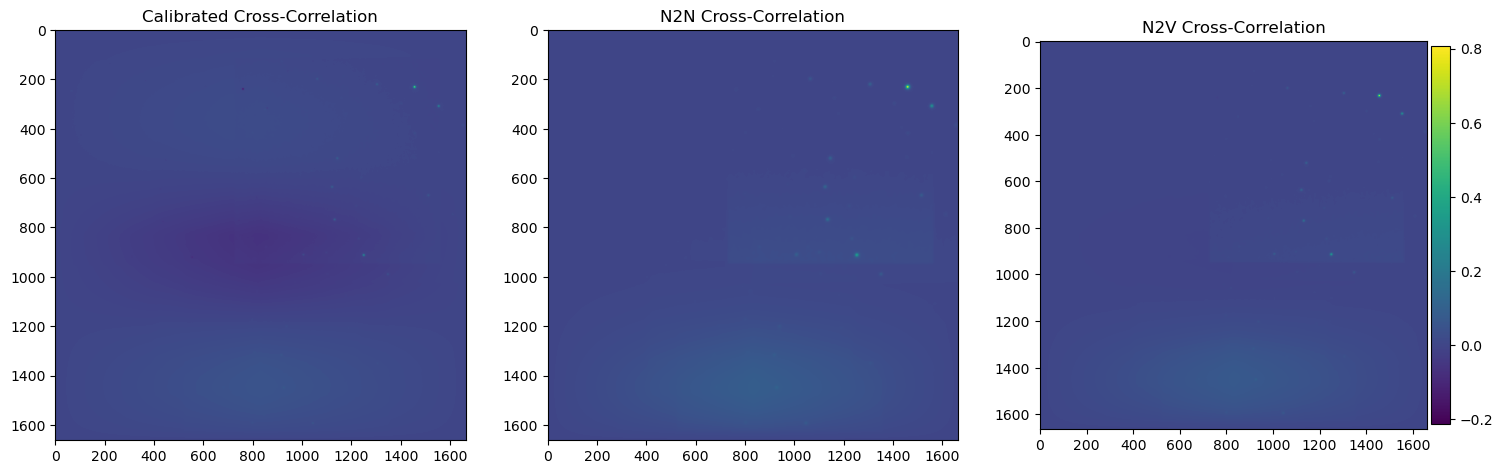

In [120]:
# Plot the 3 cross-correlations on the same colormap scale
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
vmin = min(n2n_corr.min(), n2v_corr.min(), cal_corr.min())
vmax = max(n2n_corr.max(), n2v_corr.max(), cal_corr.max())

im1 = axs[0].imshow(cal_corr, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title('Calibrated Cross-Correlation')

im2 = axs[1].imshow(n2n_corr, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title('N2N Cross-Correlation')

im3 = axs[2].imshow(n2v_corr, cmap='viridis', vmin=vmin, vmax=vmax)
axs[2].set_title('N2V Cross-Correlation')
fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.01);


There seems to be a rectangular artifact for all 3 cross-correlations, but definetly more prominent for the two nerual networks. 

Despite this, there is no correlation in the noiy regions and very high correlation between the signal regions as expected. This leads me to believe that the denoising from n2n and n2v models does preserve random noise.

## Results and Key Takeaways

### Quantifying improvement from models.

In [121]:
# Since we have SNR, CNR, and FWHM data for all three methods (baseline, N2N, N2V), we can quantify the improvement each model provides.
# We can compute the percentage improvement in SNR and CNR, and the percentage increase in FWHM for each model compared to the baseline.
snr_improvement_n2n = ((n2n_df['snr'] - cal_df['snr']) / cal_df['snr']) * 100
snr_improvement_n2v = ((n2v_df['snr'] - cal_df['snr']) / cal_df['snr']) * 100
cnr_improvement_n2n = ((n2n_df['cnr'] - cal_df['cnr']) / cal_df['cnr']) * 100
cnr_improvement_n2v = ((n2v_df['cnr'] - cal_df['cnr']) / cal_df['cnr']) * 100
fwhm_increase_n2n = ((n2n_df['fwhm'] - cal_df['fwhm']) / cal_df['fwhm']) * 100
fwhm_increase_n2v = ((n2v_df['fwhm'] - cal_df['fwhm']) / cal_df['fwhm']) * 100

# Display average improvements
print("Average SNR Improvement:")
print("N2N: {:.2f}%".format(snr_improvement_n2n.mean()))
print("N2V: {:.2f}%".format(snr_improvement_n2v.mean()))

print("Average CNR Improvement:")
print("N2N: {:.2f}%".format(cnr_improvement_n2n.mean()))
print("N2V: {:.2f}%".format(cnr_improvement_n2v.mean()))

print("Average FWHM Increase:")
print("N2N: {:.2f}%".format(fwhm_increase_n2n.mean()))
print("N2V: {:.2f}%".format(fwhm_increase_n2v.mean()))

Average SNR Improvement:
N2N: 11.09%
N2V: 9.49%
Average CNR Improvement:
N2N: 1757.63%
N2V: 2393.12%
Average FWHM Increase:
N2N: 65.81%
N2V: 23.34%


* Since higher FWHM indicates blurrier images, we want to minimize FWHM increase while maximizing SNR and CNR improvements.

* From the results, we can see that both N2N and N2V provide significant improvements in SNR and CNR compared to the baseline calibrated images.

* However, both models also lead to an increase in FWHM, indicating some loss of sharpness.

* Overall, the choice between N2N and N2V may depend on the specific requirements for SNR, CNR, and acceptable FWHM increase in the denoised images.